In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
import matplotlib as mpl
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import numpy as np
from scipy.special import erfcinv
from scipy.stats import chi2, gamma
from scipy.special import erfcinv
from scipy.linalg import sqrtm

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

import git
import os

from math import erf, sqrt

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_global = os.path.dirname(path_git)
print('Path to git repo: {}'.format(path_global))

chi2_val = chi2.ppf(0.6827, df=2)

d = 2
L = 3  # Number of vectors
n_samples = int(1e6)

Path to git repo: /home/matias/Documents/PhD/code


# PTE to $N_{\sigma}$

In [2]:
def L_iso_from_n(d: int,
                 n: float,
                 sigma2: float = 0.5,
                 gauss_scale: str = "1sigma") -> float:
    """
    Compute the Euclidean separation L between the means of two identical,
    isotropic D-dimensional Gaussian distributions with covariance
    Σ = sigma2 * I.

    The distance L is defined such that the corresponding confidence regions
    (those that in 1D would enclose ±nσ) just become tangent.

    Parameters
    ----------
    d : int
        Dimensionality of the parameter space.
    n : float
        "Number of sigmas" in 1D (i.e. associated with probability
        p = erf(n / sqrt(2))).
    sigma2 : float, optional
        Isotropic variance per dimension (default: 0.5).
    gauss_scale : {"1sigma", "2sigma"}, optional
        Interpretation of n:
        - "1sigma": use the 1D Gaussian probability within ±nσ
        - "2sigma": use the 2D chi-square CDF with df = 2

    Returns
    -------
    float
        Euclidean distance L between the two mean vectors.
    """
    scale = gauss_scale.lower()

    if scale == "1sigma":
        # 1D probability associated with ±nσ
        p = erf(n / sqrt(2.0))
        # alternatively: p = chi2.cdf(n**2, df=1)
    elif scale == "2sigma":
        # 2D probability via chi-square distribution with df=2
        p = chi2.cdf(n**2, df=2)
    else:
        raise ValueError("gauss_scale must be '1sigma' or '2sigma'.")

    # Chi-square quantile with d degrees of freedom: m^2 = χ²_{d,p}
    m2 = chi2.ppf(p, df=d)
    m = sqrt(m2)

    # Isotropic case: L = 2 σ m, with σ = sqrt(sigma2)
    return 2.0 * sqrt(sigma2) * m

print('--- Using 1sigma scale ---')
for n_val in [1, 2, 3, 4, 5]:
    print(n_val, L_iso_from_n(d=2, n=n_val))

print('--- Using 2sigma scale ---')
for n_val in [1, 2, 3, 4, 5]:
    print(n_val, L_iso_from_n(d=2, n=n_val, gauss_scale='2sigma'))


--- Using 1sigma scale ---
1 2.142778070122352
2 3.515700301858557
3 4.863981513513553
4 6.21834521588094
5 7.5820448992254725
--- Using 2sigma scale ---
1 1.4142135623730951
2 2.8284271247461903
3 4.242640687119287
4 5.656854249492375
5 7.071067811867373


L factor: 2.14, PTE: 0.0567, N_sigma: 1.91


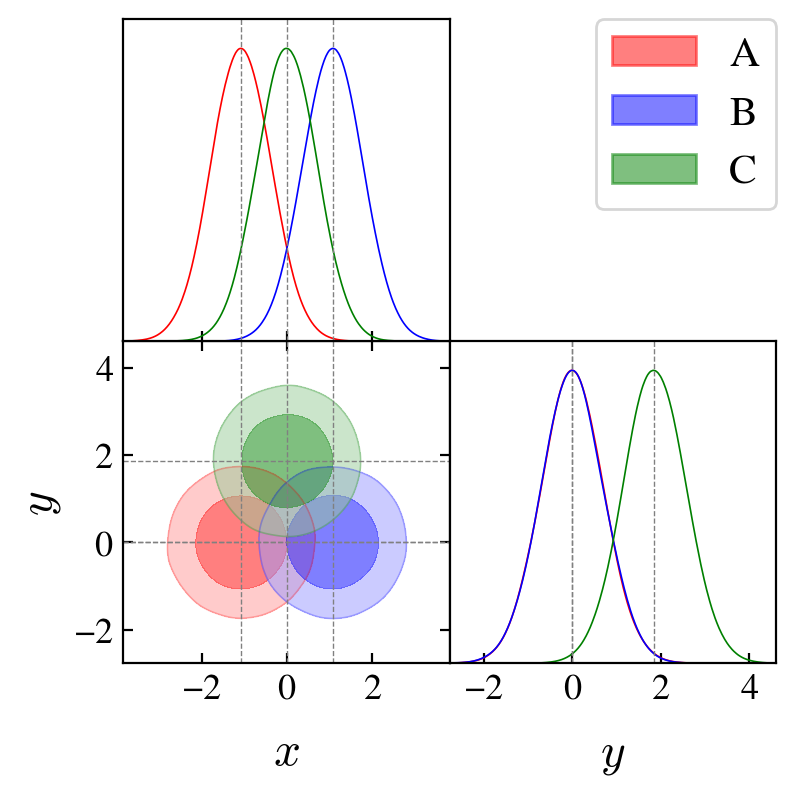

L factor: 3.52, PTE: 5.73e-05, N_sigma: 4.02


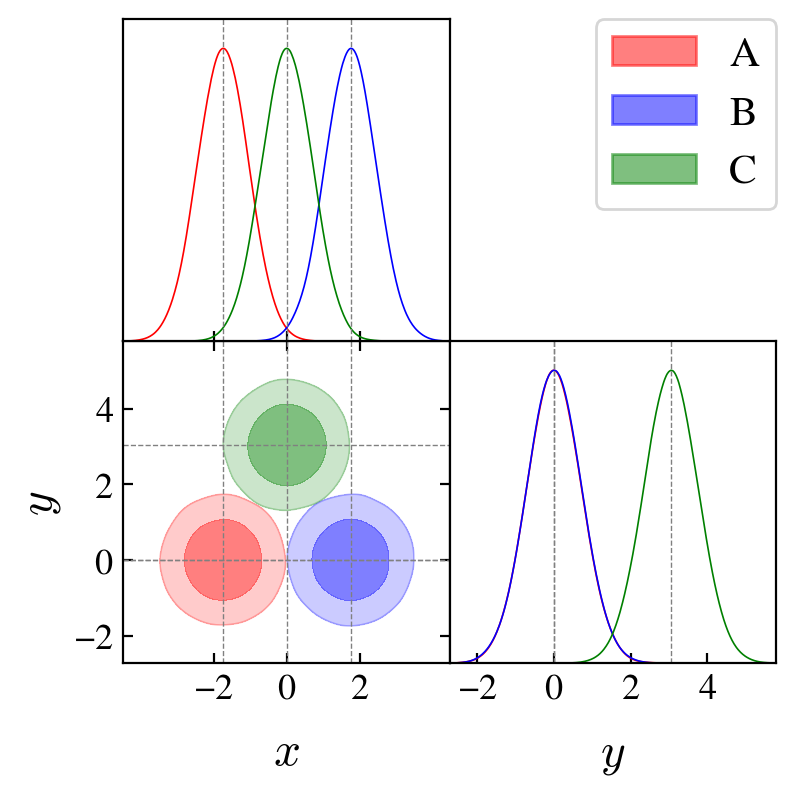

L factor: 4.86, PTE: 1.31e-09, N_sigma: 6.07


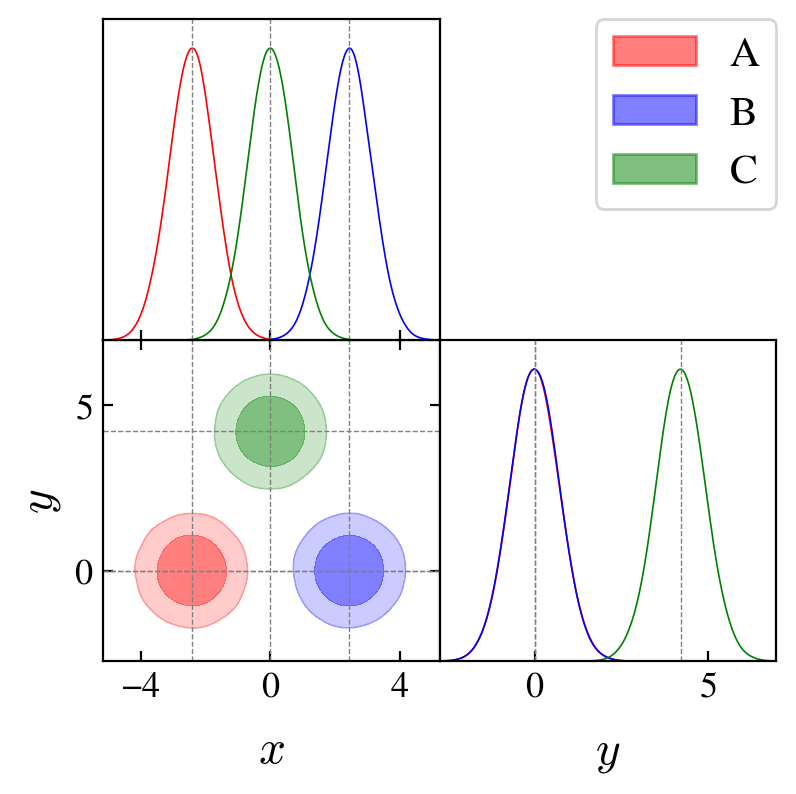

In [6]:
# Sharp triangle configuration: scale the side length using L_iso_from_n
factors = [
    L_iso_from_n(d=2, n=1),
    L_iso_from_n(d=2, n=2),
    L_iso_from_n(d=2, n=3),
]

for L_factor in factors:
    # Means placed at the vertices of an equilateral triangle
    mean_A = L_factor * np.array([-1/2., 0.])
    mean_B = L_factor * np.array([ 1/2., 0.])
    mean_C = L_factor * np.array([ 0.  , np.sqrt(3) / 2.])

    # Isotropic covariances
    cov_A = np.eye(d) / 2.0
    cov_B = cov_A.copy()
    cov_C = cov_A.copy()

    # Tension vectors
    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
    r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
    r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))

    # Quadratic tension statistic
    beta_L = (np.linalg.norm(r_1)**2
              + np.linalg.norm(r_2)**2
              + np.linalg.norm(r_3)**2) / L

    # PTE and effective N_sigma (assuming gamma distribution with shape=d)
    PTE = gamma(a=d, scale=1.0).sf(beta_L)
    n_sigma = np.sqrt(2.0) * erfcinv(PTE)

    print(f"L factor: {L_factor:.3g}, PTE: {PTE:.3g}, N_sigma: {n_sigma:.3g}")

    # ------------------------------------------------------------------
    # Triangle plot with GetDist
    # ------------------------------------------------------------------
    names = ['x', 'y']
    labels = ['x', 'y']

    samples_A = np.random.multivariate_normal(mean_A, cov_A, size=100000)
    samples_B = np.random.multivariate_normal(mean_B, cov_B, size=100000)
    samples_C = np.random.multivariate_normal(mean_C, cov_C, size=100000)

    chain_A = MCSamples(samples=samples_A, names=names, labels=labels, label='Dataset A')
    chain_B = MCSamples(samples=samples_B, names=names, labels=labels, label='Dataset B')
    chain_C = MCSamples(samples=samples_C, names=names, labels=labels, label='Dataset C')

    colors = ['red', 'blue', 'green']

    g = plots.get_subplot_plotter()
    g.settings.axes_fontsize   = 16  # tick labels
    g.settings.axes_labelsize  = 20  # axis labels
    g.settings.legend_fontsize = 18  # legend text

    g.triangle_plot(
        [chain_A, chain_B, chain_C],
        filled=True,
        contour_args={'alpha': 0.5},
        contour_colors=colors,
        legend_labels=['A', 'B', 'C'],
    )

    g.add_param_markers({
        'x': [mean_A[0], mean_B[0], mean_C[0]],
        'y': [mean_A[1], mean_B[1], mean_C[1]],
    })

    # Output directory and filenames
    output_dir = os.path.join(path_global, 'multimeter', 'notebooks', 'paper_plots', 'figures')
    os.makedirs(output_dir, exist_ok=True)

    base_name = f"multidimensional_qdm_tension_vectors_triangle_L_{L_factor:.3g}"
    g.export(os.path.join(output_dir, base_name + ".pdf"))
    g.export(os.path.join(output_dir, base_name + ".svg"))
    g.export(os.path.join(output_dir, base_name + ".png"))

    plt.show()


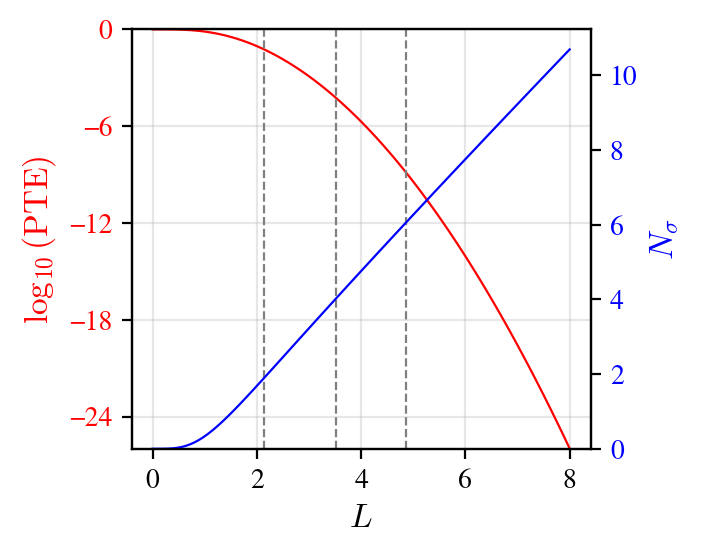

[2.142778070122352, 3.515700301858557, 4.863981513513553]


In [7]:
# Global matplotlib style (single-column figure layout)
mpl.rcParams.update({
    "figure.figsize": (3.37, 2.6),  # single-column width (inches)
    "font.size": 7,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 7,
    "lines.linewidth": 0.8,
    "font.family": "serif",
    "font.serif": ["TeX Gyre Termes", "Nimbus Roman", "Times New Roman", "DejaVu Serif"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# ----------------------------------------------------------------------
# Sharp triangle configuration: reference L values
# ----------------------------------------------------------------------
factor_line = [
    L_iso_from_n(d=2, n=1),
    L_iso_from_n(d=2, n=2),
    L_iso_from_n(d=2, n=3),
]

factor = np.linspace(0.0, 8.0, 100)
PTE_arr = np.zeros(len(factor))
n_sigma_arr = np.zeros(len(factor))

for i, L_val in enumerate(factor):
    # Means at the vertices of an equilateral triangle with side length ~ L_val
    mean_A = L_val * np.array([-1/2., 0.])
    mean_B = L_val * np.array([ 1/2., 0.])
    mean_C = L_val * np.array([ 0.  , np.sqrt(3) / 2.])

    # Isotropic covariances
    cov_A = np.eye(d) / 2.0
    cov_B = cov_A.copy()
    cov_C = cov_A.copy()

    # Tension vectors
    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
    r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
    r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))

    # Quadratic statistic in terms of the tension vectors
    beta_L = (np.linalg.norm(r_1)**2
              + np.linalg.norm(r_2)**2
              + np.linalg.norm(r_3)**2) / L

    # PTE and effective N_sigma (assuming Gamma(d, 1))
    PTE_arr[i] = gamma(a=d, scale=1.0).sf(beta_L)
    n_sigma_arr[i] = np.sqrt(2.0) * erfcinv(PTE_arr[i])

# ----------------------------------------------------------------------
# Plot log10(PTE) and N_sigma vs L
# ----------------------------------------------------------------------
# Clip PTE to avoid -inf in log10
logPTE = np.log10(np.clip(PTE_arr, 1e-300, 1.0))

fig, ax1 = plt.subplots()  # uses rcParams figure size
ax2 = ax1.twinx()

# Left y-axis: log10(PTE)
ax1.plot(factor, logPTE, color='red')
ax1.set_xlabel(r'$L$')
ax1.set_ylabel(r'$\log_{10}(\mathrm{PTE})$', color='red')
ax1.tick_params(axis='y', labelcolor='red')

from matplotlib.ticker import MaxNLocator
pmin = int(np.floor(np.nanmin(logPTE)))
pmax = int(np.ceil(np.nanmax(logPTE)))
ax1.set_ylim(pmin, pmax)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
ax1.xaxis.set_major_locator(MaxNLocator(nbins=5))

# Vertical reference lines at L-values from factor_line
for x0 in factor_line:
    ax1.axvline(x=x0, color='gray', linestyle='--', linewidth=0.8)

# Right y-axis: N_sigma
ax2.plot(factor, n_sigma_arr, color='blue')
ax2.set_ylabel(r'$N_\sigma$', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ymax = float(np.nanmax(n_sigma_arr))
ax2.set_ylim(0.0, max(1.0, 1.05 * ymax))

# Light grid on the left axis
ax1.grid(alpha=0.3)

plt.tight_layout(pad=0.02)

plt.savefig('multidimensional_qdm_tension_vectors_L_vs_PTE_Nsigma.svg',
            bbox_inches='tight')
plt.savefig('multidimensional_qdm_tension_vectors_L_vs_PTE_Nsigma.pdf',
            bbox_inches='tight')
plt.savefig('multidimensional_qdm_tension_vectors_L_vs_PTE_Nsigma.png',
            dpi=300, bbox_inches='tight')

plt.show()

print(factor_line)
